# How to Find and Plot a timeseries Level 2 Data from Multiple Granules using Python

## Overview

Level 2 data from Low Earth Orbit (LEO) satellites are often organized into \"granules\" that contain spatial sets of data that may not match up with the region of interest.  If the region is smaller than the granule, the user can create a spatial subset.  If the region spans mulitple granules, each granule may be plotted individually, or the data can be aggregated and plotted at once.  The How-to will do both of these by showing users how to find the granules in the region of interest and then subset and aggregate the variables over a long time series to create a timeseries plot over a given location.<br>

This program will download the relevant OCO-2 Level 2 Lite file data required to make a time series plot.  It could take a long time to download all of the files for a long time series but if the program is run a second time it will not download the files again if they are still in the local data directory. 

An alternative to downloading the full files would be to use the GES DISC subsetter or OPeNDAP to only download the data in the region of interest as described in the following How-Tos.  Or this program could be run in the cloud.  A function called "get_CMRgranurls" described in this How-to will return the data, OPeNDAP, and S3 urls in the region of interest.: 
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Use%20the%20Web%20Services%20API%20for%20Subsetting (using the GES DISC subsetter)
https://disc.gsfc.nasa.gov/information/howto?keywords=opendap&title=How%20to%20download%20a%20spatial%20and%20variable%20subset%20of%20Level%201B%20data%20using%20OPeNDAP (using OPeNDAP)

Citation for the OCO-2 Lite file data used in this How-To document:
OCO-2/OCO-3 Science Team, Vivienne Payne, Abhishek Chatterjee (2022), OCO-2 Level 2 bias-corrected XCO2 and other select fields from the full-physics retrieval aggregated as daily files, Retrospective processing V11.1r, Greenbelt, MD, USA, Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed: [Data Access Date], 10.5067/8E4VLCK16O6Q

The OCO-2 data in the How-to Document are also compared to the CO2 record from Scripps:
C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000. I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001.

---

This example code is written in Python 3.9 and requires these libraries and files: <br>
- numpy<br>
- requests<br>
- netCDF <br>
- matplotlib<br>
- cartopy  <br>
- netrc file with valid Earthdata Login credentials ([How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?keywords=prerequisite&title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files))<br>
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)<br>
- wget (https://www.gnu.org/software/wget/)<br>
<br>
*Note: If the files to be aggregated are not in netCDF format, a different library (e.g. Xarray) will have to be used.*

### 1. Import Libraries

In [5]:
import glob
import numpy as np
import netCDF4
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import requests
from cmr import CollectionQuery, GranuleQuery, ToolQuery, ServiceQuery, VariableQuery
import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import csv
import pdb
import pandas as pd
import time
from spacepy.time import Ticktock
from concurrent.futures import ThreadPoolExecutor


### 2. Define funtions used in this tutorial

In [6]:
def get_CMRgranurls(ShortName,VersionID,start_time,end_time,lon=None,lat=None,rad_km=None):
    """
    This program returns a dictionary with lists of data, opendap, and S3 urls.  If lon, lat, and radius are given, this function will search for all granules defined by that circle.  If lon and lat are 2 element lists, then this function will search for all granules defined by a bounding box.  If lon, lat, and radius_km are not given this function will search for all granules between the input start_time and end_time.  This function uses python-cmr to get the urls but it does not require prior knowledge of how many urls will be returned.
INPUTS
    "ShortName" the data set shortname
    "VersionID" the version ID of the product
    "start_time"  start time in utc.  The following is appended to the date: "T00:00:00Z.
    "end_time"  start time in utc The following is appended to the date: "T00:00:00Z, thus the end date is not actualy included in the results.
    "lon", "lat", "rad_km" (optional) will search within a radius or bounding box near a given location. If a radius or bounding box is not given, this function will return all granules within the input timerange.  
    OUTPUTS
    "urls" A dictionary with urls for the data, opendap, and s3 urls.  It also returns the start_time and end_time that were inputs into the program.
     
EXAMPLE
    Find all of the AIRX2RET granules within 30 km of  New Orleans
    > from opensearchtools.get_MOSurls import get_MOSurls
    > urls = get_CMRgranurls('AIRX2RET.006','2002.09.01','2016.01.01',lon=-90.0667,lat=29.95, rad_km=30.0)
    If a radius is not specified it will return all of the granules on the days in the search period.  For     example, following will return 241 granules.  The 1 extra if from 2002.08.31 part of which is on 2002.09.01
    > 
    > urls = get_CMRgranurls('AIRX2RET.006','2002.09.01','2002.09.02')
    HISTORY
    Created by Thomas Hearty,  March 14, 2016 
    """
    start_time = start_time.replace('.','-')
    end_time = end_time.replace('.','-')
    if len(start_time) == 10:
        start_time = start_time+"T00:00:00Z"
        end_time = end_time+"T00:00:00Z"

    # create a list of start and end times strings
    start_dt = datetime.datetime.fromtimestamp(time.mktime(time.strptime(start_time,"%Y-%m-%dT%H:%M:%SZ")))
    end_dt = datetime.datetime.fromtimestamp(time.mktime(time.strptime(end_time,"%Y-%m-%dT%H:%M:%SZ")))
    
    deltatime = end_dt - start_dt
    start_times = [start_time]
    end_times = []
    timeincrement = datetime.timedelta(7)
    while deltatime > timeincrement:
        old_start_dt = start_dt
        start_dt = old_start_dt+timeincrement
        end_times.append(start_dt.strftime("%Y-%m-%dT%H:%M:%SZ"))
        start_times.append(end_times[-1])
        deltatime = end_dt - start_dt
    end_times.append(end_time)
 
    s3_urls = []
    opendap_urls = []
    data_urls = []
    for start_time_seg,end_time_seg in zip(start_times,end_times):
        api = GranuleQuery()

        # there are three types of searches that I can do.  1) global, 2) bounding box, 3) point radius
        if rad_km is None and lon is None and lat is None: # this is a global search
            granules = api.short_name(ShortName).version(VersionID).temporal(start_time_seg,end_time_seg).get(1000000) 
        elif rad_km is None and len(lon) == 2 and len(lat) == 2:
            granules = api.short_name(ShortName).version(VersionID).temporal(start_time_seg,end_time_seg).bounding_box(lon[0],lat[0],lon[1],lat[1]).get(1000000)
        else: # for now I will assume it is a circle
            granules = api.short_name(ShortName).version(VersionID).temporal(start_time_seg,end_time_seg).circle(lon,lat,rad_km*1000.).get(1000000)
        
        for granule in granules:
            for link in granule.get('links',[]):
                if 'rel' in link and 'href' in link and 'inherited' not in link:
                    if 'http://esipfed.org/ns/fedsearch/1.1/s3#' in link['rel']: # It's an s3 url
                        s3_urls.append(link['href'])
                    if 'http://esipfed.org/ns/fedsearch/1.1/service#' in link['rel'] and 'opendap' in link['href']: # It's an opendap link
                        opendap_urls.append(link['href'])
                    if 'http://esipfed.org/ns/fedsearch/1.1/data#' in link['rel']: # It's a data url
                        data_urls.append(link['href'])
        
        # Get just the URLs (identified by 'via S3' in the link title)
        ###s3_urls_seg = [link['href'] for link in gran_links if 'http://esipfed.org/ns/fedsearch/1.1/s3#' in link['rel']]

        # Get just the URLs (identified by 'OPENDAP location for the granule' in the link title)
        ###opendap_urls_seg = [link['href'] for link in gran_links if 'OPENDAP location for the granule' in link['title']]

        # Finally, get just the URLs (identified by 'Download' in the link title)
        ###data_urls_seg = [link['href'] for link in gran_links if 'http://esipfed.org/ns/fedsearch/1.1/data#' in link['rel']]
            
    # we did this already, but lets do it again because the same file can appear in multiple segments.
    s3_urls = list(set(s3_urls)) # makes them unique and sorts them
    opendap_urls = list(set(opendap_urls)) # makes them unique and sorts them
    data_urls = list(set(data_urls)) # makes them unique and sorts them
    s3_urls.sort() # this will probably put them in chronological order but it must be verified.
    opendap_urls.sort() # this will probably put them in chronological order but it must be verified.
    data_urls.sort() # this will probably put them in chronological order but it must be verified.
    urls = {'s3':s3_urls,'opendap':opendap_urls,'data':data_urls}
    
    return urls,start_time,end_time

In [12]:
def dist_km(lon1_deg,lat1_deg,lon2_deg,lat2_deg):
    """
PURPOSE
    This function calculates the distance in km 
    between to points on the surface of the earth given the
    longitude and latitude of the 2 points in degrees and the assumption
    that the radius of the earth is 6371 km.
HISTORY
    Created by Thomas Hearty March 14, 2016
    """
    Rearth = 6371.0
    lat1_rad = np.radians(lat1_deg)
    lon1_rad = np.radians(lon1_deg)
    lat2_rad = np.radians(lat2_deg)
    lon2_rad = np.radians(lon2_deg)
    dist_rad = np.arccos(np.cos(lat1_rad) * np.cos(lat2_rad) * np.cos(lon1_rad - lon2_rad) + np.sin(lat1_rad) * np.sin(lat2_rad))
    dist_km = Rearth * dist_rad
    return dist_km
    

In [13]:
def list2txt(inlist,outfile):
    '''
A simple program to write a list of strings to a text file
    '''
    f = open(outfile,'w')
    for line in inlist:
        f.write(line+'\n')
    f.close()

In [51]:
# these functions are used to download a list of files.
def download_file(url, datadir):
    url = url.strip()
    filename = os.path.join(datadir, os.path.basename(url))
    if not os.path.exists(filename):
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)

def download_files(urls, datadir):
    # Read the URLs from the file
    with open(urls, 'r') as file:
        dataurls = file.readlines()
    # Use ThreadPoolExecutor to download files concurrently
    with ThreadPoolExecutor() as executor:
        # Submit download tasks to the executor
        futures = [executor.submit(download_file, url, datadir) for url in dataurls]
        # Optionally, wait for all tasks to complete
        for future in futures:
            future.result()

### 3. Define the dataset and search criteria
The ShortName and VersionID uniquely define the dataset to search.

In [14]:
ShortName = "OCO2_L2_Lite_FP"
VersionID = '11.1r'

This example will search for all OCO-2 observations within 100 km radius around Mauna Loa but this could be a set of locations.

In [15]:
title_string = "Mauna Loa"
pointlon = -155.57
pointlat = 19.536
pointradius = 100 # km
time_start = datetime.datetime(2017,1,1)
time_end = datetime.datetime(2018,1,1)

Include a point and radius of the search in the output filename.

In [16]:
datacircle_string = "{:8.3f},{:8.3f},{:8f}".format(pointlon,pointlat,pointradius).replace(' ','')
aggfile = title_string.replace(' ','')+'_'+ShortName+'.'+VersionID+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_Circle'+datacircle_string+'.nc'

### 4. Use get_CMRgranurls to get the data urls and download the files

In [17]:
# this can take a few minutes for a long time series.
urls,out_time_start,out_time_end = get_CMRgranurls(ShortName,VersionID,time_start.strftime('%Y.%m.%d'),time_end.strftime('%Y.%m.%d'),lon=pointlon,lat=pointlat,rad_km=pointradius)

In [18]:
# Create a directory based on the ShortName and VersionID to which the original data files can be downloaded
data_rootdir = './data/' 
datadir = data_rootdir +ShortName + '.' + VersionID # this is where I will download the files
if os.path.exists(datadir) is False:
    os.makedirs(datadir)

In [20]:
# save the list of urls to a text file that can be used by requests.
list2txt(urls['data'],'dataurls.txt')

In [21]:
# Download granules in parallel using the functions we defined earlier
download_files('dataurls.txt',datadir)


change the data urls to local path for the local files.

In [23]:
# save the local filesnames to a text file
localdatafiles = []
for  url in urls['data']:
    localdatafiles.append(datadir + '/' + os.path.basename(url))

list2txt(localdatafiles,'oco2L2local.txt')

### 5. Aggregate the data and save in a netCDF file
The following block of code reads the names of the local netCDF files and aggregates the data in the region of interest.

In [24]:
# names of the coordinate variables
lon_var = 'longitude'
lat_var = 'latitude'
time_var = 'time'
coordinate_vars = [lon_var,lat_var,time_var]

# names of the science variables
science_vars = ['xco2','xco2_quality_flag','Sounding/land_fraction','solar_zenith_angle']

In [25]:
# aggregated the variables if the aggregated file does not already exist.
if os.path.exists(aggfile) is True:
    # Don't create the file if it already exists
    print(aggfile+' already exists.')    
else:
    # I'll create it.        
    N=0

    # put all coordinate and science variables intothe following dictionary
    plot_dic = {}
    for var in coordinate_vars+science_vars:
        plot_dic[var] = np.array([])
    for ifile,file in enumerate(localdatafiles):
        print('Reading '+file)
        fid = netCDF4.Dataset(file ,mode='r',format='NETCDF4')
        longitude = fid.variables[lon_var][:]
        latitude = fid.variables[lat_var][:]
        dist = dist_km(pointlon,pointlat,longitude,latitude)
        validdata = dist <= pointradius
        if dist[validdata].size > 0: # there is some data within the radius
            # Now I'll fill the plot_dic with the relevant coordinate and science data
            for var in plot_dic.keys():
                plot_dic[var] = np.append(plot_dic[var],fid[var][:].data[validdata])

    # now write out all of the variables so I don't have to aggregate it again if I run the program again
    # write the aggregated variables to a netcdf file.
    ncfile = Dataset(aggfile,mode='w',format='NETCDF4')
    # create a time dimension
    time_dim = ncfile.createDimension('time', None)
    for var in plot_dic.keys():
        tmpvar = ncfile.createVariable(var, np.float64, ('time',))
        tmpvar[:] = plot_dic[var]
    ncfile.close()


MaunaLoa_OCO2_L2_Lite_FP.11.1r_20170101to20180101_Circle-155.570,19.536,100.000000.nc already exists.


### 6. Read the aggregated file

In [26]:
fid = netCDF4.Dataset(aggfile ,mode='r',format='NETCDF4')
plot_dic = {} #

for key in fid.variables.keys():
    plot_dic[key] = fid.variables[key][:].data
for group in fid.groups.keys() : # see if any data are in groups
    for key in fid.groups[group].variables.keys():
        plot_dic[group+'/'+key] =  fid.groups[group].variables[key][:].data # I'm not going any deeper than this for now.

### 7. plot XCO2 on a map

Text(0.5, 1.0, 'Mauna Loa')

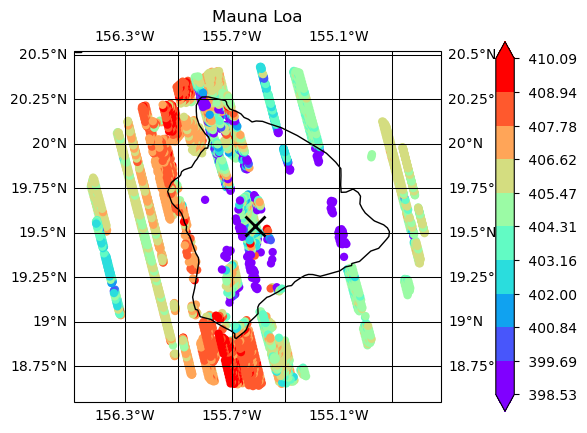

In [27]:
# although we will plot all of the values set the limits based on the good data
ocogood = plot_dic['xco2_quality_flag'] == 0
lowerlimit = np.min(plot_dic['xco2'][ocogood])
upperlimit = np.max(plot_dic['xco2'][ocogood])

mapprojection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection=mapprojection,label='allmap')
ax.coastlines()
gl=ax.gridlines(crs=mapprojection, draw_labels=True,linewidth=0.75, color='black')
ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(plot_dic['longitude'],plot_dic['latitude'],c=plot_dic['xco2'], cmap=cmap, norm=norm, edgecolor='black', linewidth=0)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
x=plt.plot([pointlon],[pointlat],marker='x',color='k',ms=15,mew=2)
ax.set_title(title_string)

In [28]:
# Save the figure to show your friends
filename = title_string.replace(' ','')+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_allmap.png'
print('Save '+filename)
fig.savefig(filename)
ax.cla()
fig.clf()

Save MaunaLoa_20170101to20180101_allmap.png


Text(0.5, 1.0, 'Mauna Loa')

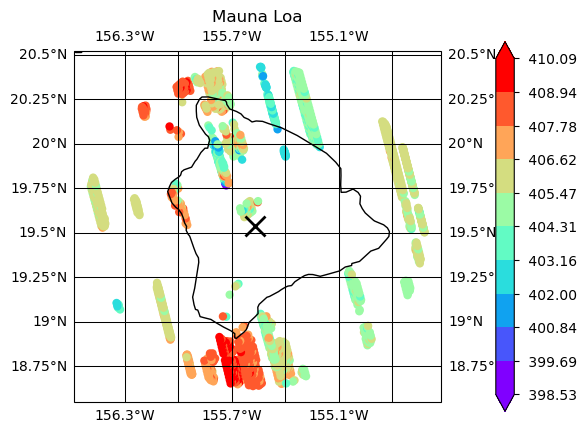

In [29]:
# Let's make the same figure but only look at the good quality data.

fig = plt.figure()
ax = plt.axes(projection=mapprojection,label='goodmap')
ax.coastlines()
gl=ax.gridlines(crs=mapprojection, draw_labels=True,linewidth=0.75, color='black')

ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(plot_dic['longitude'][ocogood],plot_dic['latitude'][ocogood],c=plot_dic['xco2'][ocogood], cmap=cmap, norm=norm, edgecolor='black', linewidth=0)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
x=plt.plot([pointlon],[pointlat],marker='x',color='k',ms=15,mew=2)
ax.set_title(title_string)


In [30]:
filename = title_string.replace(' ','')+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_goodmap.png'
print(filename)
fig.savefig(filename)
ax.cla()
fig.clf()print(aggfile)

MaunaLoa_20170101to20180101_goodmap.png


### 8. Now plot a time series of the good data from the above figure
The OCO-2 files have time measured in seconds since 1970-1-1 but plot_date requires a UTC datetime array.

In [31]:
#We can use Ticktock from spacepy to convert the TAI time in seconds since 1970-01-01 to a UTC datetime array.
t = Ticktock(plot_dic['time'][:], 'UNX')
oco2l2_utc = t.UTC

/tmp/ipykernel_2167406/2946289606.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2',color='k',marker='o')


Text(0.5, 1.0, 'Mauna Loa')

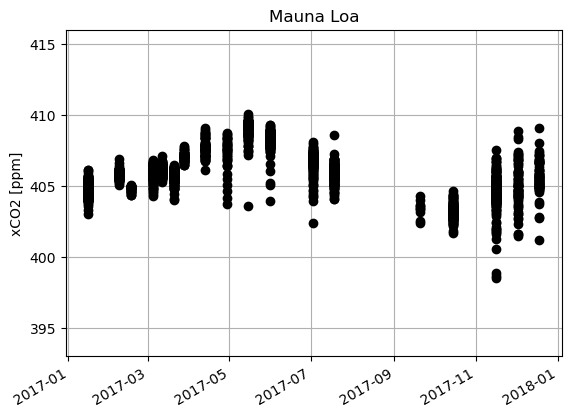

In [32]:
fig, ax = plt.subplots()
ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2',color='k',marker='o')
ax.set_ylim([np.floor(lowerlimit)-5,np.ceil(upperlimit)+5])
ax.set_ylabel('xCO2 [ppm]')
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.grid(True)
fig.autofmt_xdate()
ax.set_title(title_string)

In [33]:
filename = title_string.replace(' ','')+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_xco2_ts_oco2.png'
print(filename)
fig.savefig(filename)
ax.cla()
fig.clf()

MaunaLoa_20170101to20180101_xco2_ts_oco2.png


### 9. Finally we show how to compare the OCO-2 time series plot with daily in-situ measurements from Mauna Loa

In [34]:
# We can download and read the Mauna Loa data
url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/daily/daily_in_situ_co2_mlo.csv"
filename = url.split("/")[-1]  # Extract the filename from the URL

response = requests.get(url)

if response.status_code == 200:  # Check if the request was successful
    with open(filename, 'wb') as file:
        file.write(response.content)
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

mlo_insitu_daily = pd.read_csv('daily_in_situ_co2_mlo.csv',skiprows=13,names=['Yr','Mn','Dy','CO2','NB','scale','sta']) 

In [35]:
# Make a datetime array for the times of the Mauna Loa Observations
mlo_insitu_utc = []
for i in range(len(mlo_insitu_daily['Dy'])):
    mlo_insitu_utc.append(datetime.datetime(mlo_insitu_daily['Yr'][i],mlo_insitu_daily['Mn'][i],mlo_insitu_daily['Dy'][i]))
# convert the list of dates to an array.
mlo_insitu_utc = np.array(mlo_insitu_utc) 

In [36]:
# now convert the Mauna Loa CO2 observations to an array after converting all of the values to a floating point number.
mlo_insitu_xco2 = np.array(mlo_insitu_daily['CO2'])
for i, xco2 in enumerate(mlo_insitu_xco2):
    if 'NaN' in xco2:
        mlo_insitu_xco2[i]=-999999.0
    else:
        mlo_insitu_xco2[i] = float(xco2)
mlo_insitu_xco2 = np.array(mlo_insitu_xco2)

/tmp/ipykernel_2167406/1574962966.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(mlo_insitu_utc[mlo_valid], mlo_insitu_xco2[mlo_valid], label='In-situ',color='k',marker='x',ms=8)
/tmp/ipykernel_2167406/1574962966.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc[ocogoodland], plot_dic['xco2'][ocogoodland],label='OCO-2 L2 Land',color='r',marker='o',ms=8)
/tmp/ipykernel_2167406/1574962966.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc[ocogoodwater], plot_dic['xco2'][ocogoodwater],label='OCO-2 L2 Water',color='b',marker='o',ms=5)


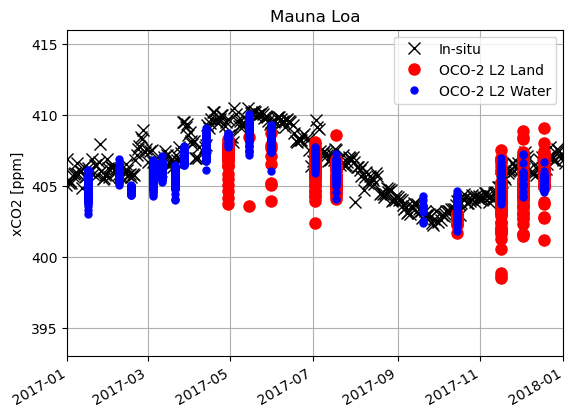

In [37]:
# for this figure we can separate the OCO-2 measurements over water and over land by using the land_fraction variable to see if there are any differences.
ocogoodland = np.logical_and(ocogood,plot_dic['Sounding/land_fraction'] > 0)
ocogoodwater = np.logical_and(ocogood,plot_dic['Sounding/land_fraction'] ==0)

mlo_valid = mlo_insitu_xco2 != -999999.
# OCO-2 data with Daily In-situ
fig, ax = plt.subplots()
ax.plot_date(mlo_insitu_utc[mlo_valid], mlo_insitu_xco2[mlo_valid], label='In-situ',color='k',marker='x',ms=8)
ax.plot_date(oco2l2_utc[ocogoodland], plot_dic['xco2'][ocogoodland],label='OCO-2 L2 Land',color='r',marker='o',ms=8)
ax.plot_date(oco2l2_utc[ocogoodwater], plot_dic['xco2'][ocogoodwater],label='OCO-2 L2 Water',color='b',marker='o',ms=5)
ax.set_xlim([time_start,time_end])
ax.set_ylim([np.floor(lowerlimit)-5,np.ceil(upperlimit)+5])
ax.set_ylabel('xCO2 [ppm]')
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.grid(True)
fig.autofmt_xdate()
ax.set_title(title_string)
plt.legend()

In [38]:
# Let's save a figure to show our friends that the OCO-2 observations over land and water both match the station measurements well but the observations over land seem to have a larger dispersion.
filename = title_string.replace(' ','')+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_xco2_ts_oco2_insitu.png'
print(filename)
fig.savefig(filename)
ax.cla()
fig.clf()

MaunaLoa_20170101to20180101_xco2_ts_oco2_insitu.png


### 10. Now we can repeat this process for another region.   The example below shows how to make similar time series of OCO-2 data within 100 km of the Caltech TCCON station.

In [43]:
# specify the dataset ShortName and VerisonID
ShortName = "OCO2_L2_Lite_FP"
VersionID = '11.1r'

# define the search criteria
title_string = "Caltech"
pointlon = -118.13
pointlat = 34.140
pointradius = 100 # km
time_start = datetime.datetime(2017,1,1)
time_end = datetime.datetime(2018,1,1)

# write a point radius string and output filename
datacircle_string = "{:8.3f},{:8.3f},{:8f}".format(pointlon,pointlat,pointradius).replace(' ','')
aggfile = title_string.replace(' ','')+'_'+ShortName+'.'+VersionID+'_'+time_start.strftime('%Y%m%d')+'to'+time_end.strftime('%Y%m%d')+'_Circle'+datacircle_string+'.nc'



In [44]:
# this can take a few minutes for a long time series.
urls,out_time_start,out_time_end = get_CMRgranurls(ShortName,VersionID,time_start.strftime('%Y.%m.%d'),time_end.strftime('%Y.%m.%d'),lon=pointlon,lat=pointlat,rad_km=pointradius)

In [54]:
# Create a directory based on the ShortName and VersionID to which the original data files can be downloaded
data_rootdir = './data/' 
datadir = data_rootdir +ShortName + '.' + VersionID # this is where I will download the files
if os.path.exists(datadir) is False:
    os.makedirs(datadir)

# save the list of urls to a text file that can be used by requests.
list2txt(urls['data'],'dataurls.txt')

# download the files
download_files('dataurls.txt',datadir)

# save the local filesnames to a text file
localdatafiles = []
for  url in urls['data']:
    localdatafiles.append(datadir + '/' + os.path.basename(url))

list2txt(localdatafiles,'oco2L2local.txt')

In [55]:
# Now we will aggregate the data for the time series and save it in a file

# names of the coordinate variables
lon_var = 'longitude'
lat_var = 'latitude'
time_var = 'time'print(aggfile)
coordinate_vars = [lon_var,lat_var,time_var]

# names of the science variables
science_vars = ['xco2','xco2_quality_flag','Sounding/land_fraction','solar_zenith_angle']

# aggregated the variables if the aggregated file does not already exist.
if os.path.exists(aggfile) is True:
    # Don't create the file if it already exists
    print(aggfile+' already exists.')    
else:
    # I'll create it.        
    N=0

    # put all coordinate and science variables intothe following dictionary
    plot_dic = {}
    for var in coordinate_vars+science_vars:
        plot_dic[var] = np.array([])
    for ifile,file in enumerate(localdatafiles):
        print('Reading '+file)
        fid = netCDF4.Dataset(file ,mode='r',format='NETCDF4')
        longitude = fid.variables[lon_var][:]
        latitude = fid.variables[lat_var][:]
        dist = dist_km(pointlon,pointlat,longitude,latitude)
        validdata = dist <= pointradius
        if dist[validdata].size > 0: # there is some data within the radius
            # Now I'll fill the plot_dic with the relevant coordinate and science data
            for var in plot_dic.keys():
                plot_dic[var] = np.append(plot_dic[var],fid[var][:].data[validdata])

    # now write out all of the variables so I don't have to aggregate it again if I run the program again
    # write the aggregated variables to a netcdf file.
    ncfile = Dataset(aggfile,mode='w',format='NETCDF4')
    # create a time dimension
    time_dim = ncfile.createDimension('time', None)
    for var in plot_dic.keys():
        tmpvar = ncfile.createVariable(var, np.float64, ('time',))
        tmpvar[:] = plot_dic[var]
    ncfile.close()

Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170101_B11100Ar_230601162724s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170102_B11100Ar_230601162755s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170103_B11100Ar_230601162825s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170104_B11100Ar_230601162855s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170105_B11100Ar_230601162926s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170106_B11100Ar_230601163138s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170107_B11100Ar_230601163138s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170108_B11100Ar_230601163158s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170109_B11100Ar_230601163327s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170110_B11100Ar_230601163354s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170111_B11100Ar_230601163623s.nc4
Reading ./data/OCO2_L2_Lite_FP.11.1r/oco2_LtCO2_170112_B11100Ar_230601163632s.nc4
Reading ./data/O

In [58]:
# Now read the aggregated file
fid = netCDF4.Dataset(aggfile ,mode='r',format='NETCDF4')
plot_dic = {} #

for key in fid.variables.keys():
    plot_dic[key] = fid.variables[key][:].data
for group in fid.groups.keys() : # see if any data are in groups
    for key in fid.groups[group].variables.keys():
        plot_dic[group+'/'+key] =  fid.groups[group].variables[key][:].data # I'm not going any deeper than this for now.

Text(0.5, 1.0, 'Caltech')

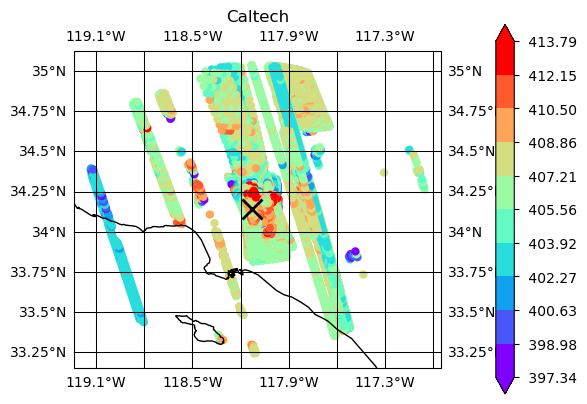

In [59]:
# although we will plot all of the values set the limits based on the good data
ocogood = plot_dic['xco2_quality_flag'] == 0
lowerlimit = np.min(plot_dic['xco2'][ocogood])
upperlimit = np.max(plot_dic['xco2'][ocogood])

mapprojection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection=mapprojection,label='allmap')
ax.coastlines()
gl=ax.gridlines(crs=mapprojection, draw_labels=True,linewidth=0.75, color='black')
ncolors=10
cmap=plt.cm.rainbow
bounds = np.linspace(lowerlimit,upperlimit,ncolors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
c=plt.scatter(plot_dic['longitude'],plot_dic['latitude'],c=plot_dic['xco2'], cmap=cmap, norm=norm, edgecolor='black', linewidth=0)
plt.colorbar(ax=ax, orientation="vertical", pad=0.110, spacing='proportional', ticks=bounds, boundaries=bounds, format='%7.2f', extend = "both")
x=plt.plot([pointlon],[pointlat],marker='x',color='k',ms=15,mew=2)
ax.set_title(title_string)

/tmp/ipykernel_2167406/582496391.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc, plot_dic['xco2'],label='OCO-2 L2',color='k',marker='x')
/tmp/ipykernel_2167406/582496391.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2 Land',color='g',marker='o',ms=8)


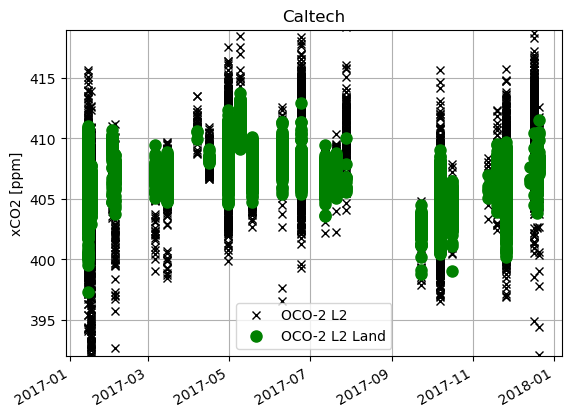

In [62]:
#Now lets plot a time series of the data and overplot the good data in green.

#We can use Ticktock from spacepy to convert the TAI time in seconds since 1970-01-01 to a UTC datetime array.
t = Ticktock(plot_dic['time'][:], 'UNX')
oco2l2_utc = t.UTC

fig, ax = plt.subplots()
ax.plot_date(oco2l2_utc, plot_dic['xco2'],label='OCO-2 L2',color='k',marker='x')
ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2 Good',color='g',marker='o',ms=8)
ax.set_ylim([np.floor(lowerlimit)-5,np.ceil(upperlimit)+5])
ax.set_ylabel('xCO2 [ppm]')
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.grid(True)
fig.autofmt_xdate()
ax.set_title(title_string)
plt.legend()

In [65]:
# Now lets compare the OCO-2 data with TCCON measurements.

# We can download and read the TCCON data for Caltech
url = "https://renc.osn.xsede.org/ini210004tommorrell/10.14291/tccon.ggg2020.pasadena01.R0/ci20120920_20240421.public.qc.nc"
download_file(url, './')

fidtccon = netCDF4.Dataset(os.path.basename(url) ,mode='r',format='NETCDF4')

In [67]:
fidtccon.variables.keys()

dict_keys(['time', 'prior_time', 'prior_altitude', 'ak_altitude', 'ak_pressure', 'ak_xco2', 'extrapolation_flags_ak_xco2', 'ak_xwco2', 'extrapolation_flags_ak_xwco2', 'ak_xlco2', 'extrapolation_flags_ak_xlco2', 'ak_xch4', 'extrapolation_flags_ak_xch4', 'ak_xhf', 'extrapolation_flags_ak_xhf', 'ak_xo2', 'extrapolation_flags_ak_xo2', 'ak_xn2o', 'extrapolation_flags_ak_xn2o', 'ak_xco', 'extrapolation_flags_ak_xco', 'ak_xh2o', 'extrapolation_flags_ak_xh2o', 'prior_temperature', 'prior_pressure', 'prior_density', 'prior_h2o', 'prior_co2', 'prior_n2o', 'prior_co', 'prior_ch4', 'prior_o2', 'prior_hf', 'prior_hdo', 'prior_gravity', 'prior_equivalent_latitude', 'prior_tropopause_altitude', 'prior_effective_latitude', 'prior_mid_tropospheric_potential_temperature', 'gfit_version', 'gsetup_version', 'year', 'day', 'hour', 'lat', 'long', 'zobs', 'zmin', 'solzen', 'azim', 'tout', 'pout', 'hout', 'sia', 'fvsi', 'wspd', 'wdir', 'xluft', 'xluft_error', 'xhf', 'xhf_error', 'xh2o', 'xh2o_error', 'xhdo', 

In [69]:
# Ticktock can also convert the TCCON time can also be converted to a UTC datetime array
t = Ticktock(fidtccon.variables['time'][:], 'UNX')
tccon_utc = t.UTC

/tmp/ipykernel_2167406/1965923777.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(tccon_utc, fidtccon.variables['xco2'][:],label='TCCON XCO2',color='k',marker='x')
/tmp/ipykernel_2167406/1965923777.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2 Good',color='g',marker='o',ms=8)


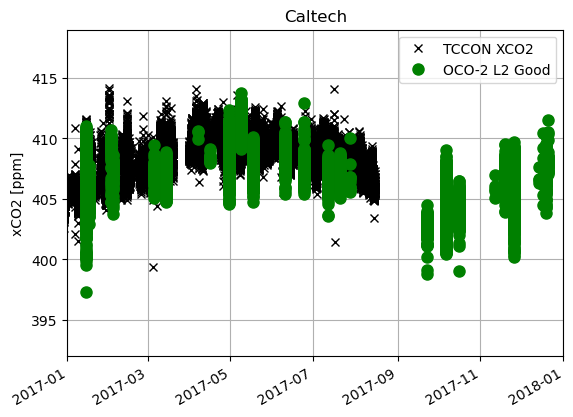

In [73]:
fig, ax = plt.subplots()
ax.plot_date(tccon_utc, fidtccon.variables['xco2'][:],label='TCCON XCO2',color='k',marker='x')
ax.plot_date(oco2l2_utc[ocogood], plot_dic['xco2'][ocogood],label='OCO-2 L2 Good',color='g',marker='o',ms=8)
ax.set_xlim([time_start,time_end])
ax.set_ylim([np.floor(lowerlimit)-5,np.ceil(upperlimit)+5])
ax.set_ylabel('xCO2 [ppm]')
ax.fmt_xdata = DateFormatter('%Y-%m-%d')
ax.grid(True)
fig.autofmt_xdate()
ax.set_title(title_string)
plt.legend()